In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#train = pd.read_csv('/kaggle/input/recsysmasterfds-2024/train.csv')
complete_train = pd.read_csv('/content/drive/My Drive/_Universität_HPI/Semester 6/Recommenders/Assignments/Assignment 1/data/train.csv')

In [ ]:
from sklearn.model_selection import train_test_split
small_train, small_val = train_test_split(complete_train, test_size=0.2, random_state=42)

In [ ]:
#filtered_df = traindata[traindata['user_id'] <= 100]
#filtered_df.to_csv('/content/drive/My Drive/_Universität_HPI/Semester 6/Recommenders/Assignments/Assignment 1/Attempts/smalldata.csv', index=False)

In [ ]:
#filtered_df.shape
#traindata= filtered_df

In [ ]:
test = pd.read_csv('/content/drive/My Drive/_Universität_HPI/Semester 6/Recommenders/Assignments/Assignment 1/givenExample/kaggle_baseline.csv')

# Data Analysis and Preprocessing


## Analysis and Overview

In [ ]:
print(train.head())
print(train.info())
print(train.describe())
for column in ['user_id', 'title', 'movie_id', 'sex']:
    print(f"{column}: {train[column].nunique()}")

   user_id                title  movie_id  rating         release_date  sex  \
0     2592       Top Gun (1986)      1101       4       Action|Romance   50   
1     4318  12 Angry Men (1957)      1203       4                Drama   25   
2     2756     Robocop 2 (1990)      2986       2  Action|Crime|Sci-Fi   18   
3     1706  Modern Times (1936)      3462       5               Comedy   25   
4     4813    Milk Money (1994)       276       3       Comedy|Romance   35   

  age  
0   M  
1   M  
2   M  
3   M  
4   F  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800167 entries, 0 to 800166
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       800167 non-null  int64 
 1   title         800167 non-null  object
 2   movie_id      800167 non-null  int64 
 3   rating        800167 non-null  int64 
 4   release_date  800167 non-null  object
 5   sex           800167 non-null  int64 
 6   age           8001

In [ ]:
train['user_id'].nunique()

6040

In [ ]:
train.shape

(800167, 7)

In [ ]:
user_ages = train[train['movie_id'] == 1101]['release_date']
print(user_ages.unique())

['Action|Romance']


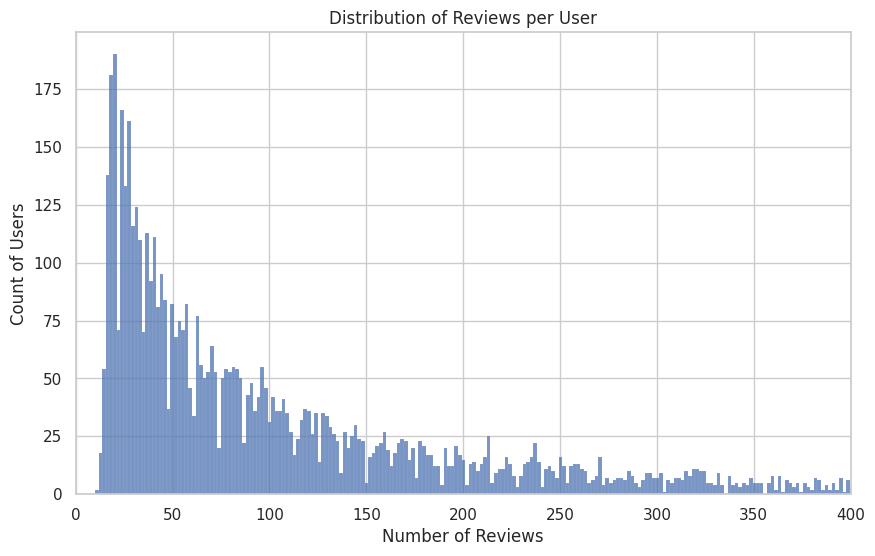

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame

# Calculate the number of reviews per user
reviews_per_user = train['user_id'].value_counts()

# Set the style of the seaborn plot
sns.set(style="whitegrid")


# Create the plot
plt.figure(figsize=(10, 6))  # You can adjust the size as needed
sns.histplot(reviews_per_user, bins=1000, kde=False)  # Adjust bins for better resolution if needed

# Set the title and labels
plt.title('Distribution of Reviews per User')
plt.xlabel('Number of Reviews')
plt.ylabel('Count of Users')

plt.xlim(0, 400)  # Set x-axis limit to 750

# Show the plot
plt.show()


,user_id,prediction
0,850,260 1210 480 2028 589 1270 593 1580 110 2396 1...
1,2012,2858 2028 593 608 2762 110 2396 1617 527 2997 ...
2,1511,2858 260 480 589 1270 593 1580 608 2762 110 23...
3,5846,1196 1210 480 2028 589 2571 1270 1580 1198 276...
4,4344,593 2716 1 3578 2987 919 3175 924 1387 2355 10...


In [ ]:
test.shape

(6037, 2)

## Preprocessing

# Baseline Recommender

In [ ]:
class TopPopRecommender():

    def fit(self, train):

        item_popularity = train[['movie_id','rating']].groupby(by='movie_id').count()

        self.train = train
        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popular_items = item_popularity.sort_values(by='rating',ascending=False).index


    def predict_top(self, user_id, at=5, remove_seen=True):

        if remove_seen:
            seen_items = self.train[self.train.user_id==user_id].movie_id.values
            unseen_items_mask = np.in1d(self.popular_items, seen_items, assume_unique=True, invert = True)
            unseen_items = self.popular_items[unseen_items_mask]
            recommended_items = unseen_items[0:at]

        else:
            recommended_items = self.popular_items[0:at]

        return recommended_items

In [ ]:
import csv


topPopular = TopPopRecommender()
topPopular.fit(complete_train)

# open the file in the write mode
with open('/content/drive/My Drive/_Universität_HPI/Semester 6/Recommenders/Assignments/Assignment 1/Attempts/attemptsolutions/solution1.csv', 'w',encoding='UTF8') as f:
    # create the csv writer
    writer = csv.writer(f)
    # write a row to the csv file
    writer.writerow(['user_id', 'prediction'])
    for user_id in test.user_id.unique():
        relevant_items = topPopular.predict_top(user_id, at=25)
        list_relevants = ' '.join([str(elem) for elem in relevant_items])
        writer.writerow([str(user_id),list_relevants])

NameError: name 'train' is not defined

# Neighborhood based Recommender

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error


class NeighborhoodBased():

    def fit(self):
        self.c= 0
        # Creating a user-item matrix for training data
        self.user_item_matrix = train.pivot_table(index='user_id', columns='movie_id', values='rating').fillna(0)
        # Creating a sparse matrix
        self.sparse_user_item = csr_matrix(self.user_item_matrix.values)
        # Computing the cosine similarity matrix (user-user)
        self.user_similarity = cosine_similarity(self.sparse_user_item, dense_output=False)
        # Convert the similarity matrix to a DataFrame for easier manipulation
        self.user_similarity_df = pd.DataFrame(self.user_similarity.toarray(), index=self.user_item_matrix.index, columns=self.user_item_matrix.index)
        # Display the user similarity matrix
        self.user_similarity_df.head()

    def predict_rating(self, user_id, movie_id, k=10):
        """
        Predict the rating that a user would give to a movie based on user-user similarity

        Parameters:
        - user_id: target user ID
        - movie_id: movie ID for the rating prediction
        - user_similarity_df: DataFrame of user-user similarities
        - user_item_matrix: DataFrame of user-item ratings
        - k: number of similar users to consider

        Returns:
        - predicted_rating: the predicted rating for the movie
        """
        # Check if movie_id exists in user_item_matrix
        if movie_id not in self.user_item_matrix.columns:
            # If not, return the global average rating
            return self.user_item_matrix.values.mean()

        # Find the similarity scores for the target user and sort them
        similars = self.user_similarity_df[user_id].sort_values(ascending=False)

        # Select top-k similar users, excluding the target user itself
        top_similars = similars.iloc[1:k+1]

        # Filter ratings of these users for the given movie
        similar_users_ratings = self.user_item_matrix.loc[top_similars.index][movie_id]

        # Filter out missing ratings
        similar_users_ratings = similar_users_ratings[similar_users_ratings > 0]

        # Calculate the weighted average rating if there are similar users who rated the movie
        if similar_users_ratings.shape[0] > 0:
            predicted_rating = np.dot(similar_users_ratings, top_similars[similar_users_ratings.index]) / top_similars[similar_users_ratings.index].sum()
        else:
            # If no similar users have rated the movie, use the movie's average rating
            predicted_rating = self.user_item_matrix[movie_id].mean()
        #print(self.c)
        self.c=self.c+1
        return predicted_rating

    def evaluate_model(self, validation_set, k=50):
        """
        Evaluates the collaborative filtering model using Root Mean Squared Error (RMSE)

        Parameters:
        - validation_set: DataFrame containing user_id, movie_id, and actual ratings
        - user_similarity_df: DataFrame of user-user similarities
        - user_item_matrix: DataFrame of user-item ratings
        - k: number of similar users to consider

        Returns:
        - RMSE of the model on the validation set
        """
        # Predict ratings for the validation set
        y_pred = validation_set.apply(lambda x: self.predict_rating(x['user_id'], x['movie_id'], k), axis=1)
        y_true = validation_set['rating']

        # Calculate and return the RMSE
        return np.sqrt(mean_squared_error(y_true, y_pred))

# Evaluate the initial model on the validation set

In [ ]:
NB = NeighborhoodBased()
NB.fit()

rmse = NB.evaluate_model(val)
rmse

In [ ]:
small_val.shape

(160034, 7)

In [ ]:
import random
y_random = pd.Series(np.random.randint(3, 6, size=160034))

In [ ]:
np.sqrt(mean_squared_error(y_random, small_val['rating'] ))

1.4453459213015936

In [ ]:
class NeighborhoodBased2():

    def __init__(self, shrink=100, k=10):
        self.shrink = shrink
        self.k = k

    def fit(self, train):
        print("Fitting model...")
        # Creating user-item matrix from training data
        self.train_data = train
        self.user_item_matrix = self.train_data.pivot_table(index='user_id', columns='movie_id', values='rating', fill_value=0)

        # Index mapping for users and movies
        self.users = self.user_item_matrix.index.tolist()
        self.movies = self.user_item_matrix.columns.tolist()
        self.user_map = {user: index for index, user in enumerate(self.users)}
        self.movie_map = {movie: index for index, movie in enumerate(self.movies)}

        # Computing the cosine similarity matrix for users
        sparse_user_item = csr_matrix(self.user_item_matrix.values)
        self.user_similarity = cosine_similarity(sparse_user_item, dense_output=True)

        # Apply shrinkage factor to similarity scores
        num_interactions = sparse_user_item.getnnz(axis=1)
        self.user_similarity = self.user_similarity / (1 + self.shrink / (num_interactions[:, np.newaxis] + 1e-6))

        # Setting similarity with oneself to zero
        np.fill_diagonal(self.user_similarity, 0)

    def predict_rating(self, user_id, movie_id):
        if movie_id not in self.movie_map or user_id not in self.user_map:
            return np.mean(self.user_item_matrix.values)

        user_index = self.user_map[user_id]
        movie_index = self.movie_map[movie_id]

        similar_users = np.argsort(self.user_similarity[user_index])[::-1][:self.k]
        similarities = self.user_similarity[user_index, similar_users]

        # Ratings by the top-k similar users for the movie
        similar_users_ratings = self.user_item_matrix.values[similar_users, movie_index]

        # Exclude users who have not rated the movie
        mask = similar_users_ratings > 0
        similar_users_ratings = similar_users_ratings[mask]
        similarities = similarities[mask]

        if similar_users_ratings.size == 0:
            return np.mean(self.user_item_matrix.values)

        # Weighted sum of ratings
        predicted_rating = np.dot(similarities, similar_users_ratings) / np.sum(similarities)
        return predicted_rating

    def evaluate_model(self, validation_set):
        y_true = validation_set['rating'].values
        y_pred = [self.predict_rating(row['user_id'], row['movie_id']) for _, row in validation_set.iterrows()]

        # Calculate and return the RMSE
        return np.sqrt(mean_squared_error(y_true, y_pred))

# Example of using the improved model
model = NeighborhoodBased2(shrink=100, k=50)
model.fit(train)  # Assuming 'train' is your training dataset
rmse = model.evaluate_model(val)  # Assuming 'validation' is your validation dataset
print(f"RMSE: {rmse}")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error

class NeighborhoodBasedEnhanced():
    def __init__(self, similarity_threshold=0.1):
        self.similarity_threshold = similarity_threshold

    def fit(self, train):
        self.train = train
        print("Fitting model...")
        self.user_item_matrix = train.pivot_table(index='user_id', columns='movie_id', values='rating', fill_value=0)
        sparse_user_item = csr_matrix(self.user_item_matrix.values)
        self.user_similarity = cosine_similarity(sparse_user_item, dense_output=True)
        np.fill_diagonal(self.user_similarity, 0)
        self.global_average_rating = train['rating'].mean()

    def predict_rating(self, user_id, movie_id):
        if movie_id not in self.user_item_matrix.columns or user_id not in self.user_item_matrix.index:
            # Fallback to global average if user or movie is unknown
            return self.global_average_rating

        similarities = self.user_similarity[self.user_item_matrix.index == user_id].flatten()
        ratings = self.user_item_matrix[movie_id].values
        mask = (similarities > self.similarity_threshold) & (ratings > 0)

        if not np.any(mask):
            # Fallback to movie's average rating if there are no similar users
            return self.user_item_matrix[movie_id].mean()

        weighted_ratings = np.dot(ratings[mask], similarities[mask])
        sum_of_similarities = np.sum(similarities[mask])

        return weighted_ratings / sum_of_similarities if sum_of_similarities > 0 else self.global_average_rating

    def evaluate_model(self, validation_set):
        y_pred = validation_set.apply(lambda x: self.predict_rating(x['user_id'], x['movie_id']), axis=1)
        y_true = validation_set['rating']

        return np.sqrt(mean_squared_error(y_true, y_pred))

    def recommend_movies(self, user_id, N=25):
        """
        Recommend N movies for a user that they have not yet rated.

        Parameters:
        - user_id: the user ID for whom to make recommendations
        - user_similarity_df: DataFrame of user-user similarities
        - user_item_matrix: DataFrame of user-item ratings
        - N: Number of top recommendations to return

        Returns:
        - recommendations: DataFrame of top N recommended movies with predicted ratings
        """
        # Find all movies that the user has not rated yet
        rated_movies = self.user_item_matrix.loc[user_id][self.user_item_matrix.loc[user_id] > 0].index
        unrated_movies = self.user_item_matrix.columns.difference(rated_movies)

        # Predict ratings for all unrated movies
        predictions = {movie: self.predict_rating(user_id, movie) for movie in unrated_movies}

        # Sort the predicted ratings
        sorted_predictions = sorted(predictions.items(), key=lambda x: x[1], reverse=True)

        # Take the top N predictions
        top_n_predictions = sorted_predictions[:N]
        top_n_movie_ids = [movie[0] for movie in top_n_predictions]
        top_n_predicted_ratings = [movie[1] for movie in top_n_predictions]

        # Return the top N recommendations
        recommendations = pd.DataFrame({'movie_id': top_n_movie_ids, 'predicted_rating': top_n_predicted_ratings})

        return top_n_movie_ids

# Assuming 'train' and 'validation' are already loaded as Pandas DataFrames
model_enhanced = NeighborhoodBasedEnhanced(similarity_threshold=0.005)
model_enhanced.fit(small_train)
rmse = model_enhanced.evaluate_model(small_val)
print(f"RMSE: {rmse}")
print(model_enhanced.recommend_movies(1))
#tqdm

Fitting model...
RMSE: 0.9731179386108313
[3233, 687, 823, 1360, 1886, 3382, 3607, 3800, 3881, 53, 3245, 2905, 3338, 214, 318, 3522, 745, 858, 2019, 3951, 50, 1871, 557, 720, 2444]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from tqdm import tqdm
from sklearn.metrics.pairwise import pairwise_distances

## Hier pearson statt cosine (nur minimal besser)

class NeighborhoodBasedEnhanced1a2():
    def __init__(self, similarity_threshold=0.1):
        self.similarity_threshold = similarity_threshold
        self.global_average_rating = 0
        self.topPopular = TopPopRecommender()

    def fit(self, train):
        print("Fitting model...")
        # Store the original data
        self.train = train.copy()
        self.topPopular.fit(train)

        # Calculate global average rating
        self.global_average_rating = train['rating'].mean()

        # Creating a user-item matrix with raw ratings
        self.user_item_matrix = train.pivot_table(index='user_id', columns='movie_id', values='rating', fill_value=0)
        # Convert to sparse matrix format to save memory
        self.sparse_user_item = csr_matrix(self.user_item_matrix.values)

        # Calculating cosine similarities (used as a proxy for Pearson correlation due to memory issues)
        print("Calculating similarities...")
        self.user_similarity = cosine_similarity(self.sparse_user_item)
        np.fill_diagonal(self.user_similarity, 0)  # Zero out diagonals (self-similarity)

    def predict_rating(self, user_id, movie_id):
        # Check if user and movie exist in the training set
        if movie_id not in self.user_item_matrix.columns or user_id not in self.user_item_matrix.index:
            return self.global_average_rating

        user_index = self.user_item_matrix.index.get_loc(user_id)

        # Compute weighted sum of similarities and ratings
        similarities = self.user_similarity[user_index]
        ratings = self.user_item_matrix.values[:, self.user_item_matrix.columns.get_loc(movie_id)]

        # Only consider users with a similarity score above the threshold and non-zero ratings
        valid_indices = (similarities > self.similarity_threshold) & (ratings > 0)
        valid_similarities = similarities[valid_indices]
        valid_ratings = ratings[valid_indices]

        # Calculate the predicted rating
        if valid_similarities.size > 0:
            predicted_rating = np.dot(valid_similarities, valid_ratings) / valid_similarities.sum()
        else:
            predicted_rating = self.global_average_rating

        return predicted_rating

    def evaluate_model(self, validation_set):
        print("Evaluating model...")
        predictions = [self.predict_rating(row['user_id'], row['movie_id']) for _, row in tqdm(validation_set.iterrows(), total=validation_set.shape[0])]
        y_true = validation_set['rating'].tolist()
        return np.sqrt(mean_squared_error(y_true, predictions))


    def recommend_movies(self, user_id, N=25):
        # Find the top 50 popular movies that the user has not rated yet
        rated_movies = self.user_item_matrix.loc[user_id][self.user_item_matrix.loc[user_id] > 0].index
        unrated_movies = self.topPopular.predict_top(user_id, at=70)

        # Predict ratings for all unrated movies
        predictions = {movie: self.predict_rating(user_id, movie) for movie in unrated_movies}

        # Sort the predicted ratings
        sorted_predictions = sorted(predictions.items(), key=lambda x: x[1], reverse=True)

        # Take the top N predictions
        top_n_predictions = sorted_predictions[:N]
        top_n_movie_ids = [movie[0] for movie in top_n_predictions]
        ordered_top_n_movie_ids = [movie for movie in unrated_movies if movie in top_n_movie_ids]

        return ordered_top_n_movie_ids



model_enhanced1a2 = NeighborhoodBasedEnhanced1a2(similarity_threshold=0.005)
model_enhanced1a2.fit(small_train)
rmse = model_enhanced1a2.evaluate_model(small_val)
print(f"RMSE: {rmse}")
print(model_enhanced1a2.recommend_movies(1))

Fitting model...
Calculating similarities...
Evaluating model...


100%|██████████| 160034/160034 [00:24<00:00, 6422.10it/s]


RMSE: 0.9730623663099512
[2858, 1196, 260, 2028, 2571, 593, 1198, 110, 2396, 1617, 858, 318, 2997, 296, 1240, 541, 50, 919, 1221, 912, 1291, 1213, 1136, 1704, 1304]


In [ ]:

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD


# Item-based stat User-based (schlechter!)

class NeighborhoodBasedEnhanced3a():
    def __init__(self, similarity_threshold=0.1, n_components=100):
        self.similarity_threshold = similarity_threshold
        self.n_components = n_components  # Number of components for SVD
        self.topPopular = TopPopRecommender()  # Assuming definition elsewhere

    def fit(self, train):
        self.train = train
        self.topPopular.fit(train)
        print("Fitting model...")
        self.item_user_matrix = train.pivot_table(index='movie_id', columns='user_id', values='rating', fill_value=0)
        # Apply SVD
        svd = TruncatedSVD(n_components=self.n_components)
        item_user_reduced = svd.fit_transform(self.item_user_matrix)
        # Compute item similarities from the reduced matrix
        self.item_similarity = cosine_similarity(item_user_reduced, dense_output=True)
        np.fill_diagonal(self.item_similarity, 0)
        self.global_average_rating = train['rating'].mean()



    def predict_rating(self, user_id, movie_id):
        if movie_id not in self.item_user_matrix.index or user_id not in self.item_user_matrix.columns:
            # Fallback to global average if movie or user is unknown
            return self.global_average_rating

        similarities = self.item_similarity[self.item_user_matrix.index == movie_id].flatten()
        ratings = self.item_user_matrix.loc[:, user_id].values
        mask = (similarities > self.similarity_threshold) & (ratings > 0)

        if not np.any(mask):
            # Fallback to user's average rating if there are no similar items
            return self.item_user_matrix.loc[:, user_id].mean()

        weighted_ratings = np.dot(ratings[mask], similarities[mask])
        sum_of_similarities = np.sum(similarities[mask])

        return weighted_ratings / sum_of_similarities if sum_of_similarities > 0 else self.global_average_rating

    def evaluate_model(self, validation_set):
        y_pred = validation_set.apply(lambda x: self.predict_rating(x['user_id'], x['movie_id']), axis=1)
        y_true = validation_set['rating']

        return np.sqrt(mean_squared_error(y_true, y_pred))

    def recommend_movies(self, user_id, N=25):
        # Find the top N popular items that the user has not rated yet
        rated_movies = self.item_user_matrix.loc[:, user_id][self.item_user_matrix.loc[:, user_id] > 0].index
        unrated_movies = self.topPopular.predict_top(user_id, at=N)  # Assuming definition elsewhere

        # Predict ratings for all unrated movies
        predictions = {movie: self.predict_rating(user_id, movie) for movie in unrated_movies if movie not in rated_movies}

        # Sort the predicted ratings
        sorted_predictions = sorted(predictions.items(), key=lambda x: x[1], reverse=True)

        # Take the top N predictions
        top_n_predictions = sorted_predictions[:N]
        top_n_movie_ids = [movie[0] for movie in top_n_predictions]

        return top_n_movie_ids


# Usage example
model_enhanced3a = NeighborhoodBasedEnhanced3a(similarity_threshold=0.005)
model_enhanced3a.fit(small_train)  # small_train is assumed to be defined elsewhere
rmse = model_enhanced3a.evaluate_model(small_val)  # small_val is assumed to be defined elsewhere
print(f"RMSE: {rmse}")
print(model_enhanced3a.recommend_movies(1))


Fitting model...
RMSE: 1.000435087700902
[260, 2028, 1196, 480, 858, 110, 1198, 1240, 1097, 1617, 318, 593, 1210, 296, 1270, 356, 2396, 2716, 2858, 589, 1580, 2997, 2571, 2628, 1265]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error

class NeighborhoodBasedEnhanced1a():
    def __init__(self, similarity_threshold=0.1):
        self.similarity_threshold = similarity_threshold
        self.topPopular = TopPopRecommender()

    def fit(self, train):
        self.train = train
        self.item_popularity = train[['movie_id','rating']].groupby(by='movie_id').count()
        self.topPopular.fit(train)
        print("Fitting model...")
        self.user_item_matrix = train.pivot_table(index='user_id', columns='movie_id', values='rating', fill_value=0)
        sparse_user_item = csr_matrix(self.user_item_matrix.values)
        self.user_similarity = cosine_similarity(sparse_user_item, dense_output=True)
        np.fill_diagonal(self.user_similarity, 0)
        self.global_average_rating = train['rating'].mean()

    def predict_rating(self, user_id, movie_id):
        if movie_id not in self.user_item_matrix.columns or user_id not in self.user_item_matrix.index:
            # Fallback to global average if user or movie is unknown
            return self.global_average_rating

        similarities = self.user_similarity[self.user_item_matrix.index == user_id].flatten()
        ratings = self.user_item_matrix[movie_id].values
        mask = (similarities > self.similarity_threshold) & (ratings > 0)

        if not np.any(mask):
            # Fallback to movie's average rating if there are no similar users
            return self.user_item_matrix[movie_id].mean()

        weighted_ratings = np.dot(ratings[mask], similarities[mask])
        sum_of_similarities = np.sum(similarities[mask])

        return weighted_ratings / sum_of_similarities if sum_of_similarities > 0 else self.global_average_rating

    def evaluate_model(self, validation_set):
        y_pred = validation_set.apply(lambda x: self.predict_rating(x['user_id'], x['movie_id']), axis=1)
        y_true = validation_set['rating']

        return np.sqrt(mean_squared_error(y_true, y_pred))

    def recommend_movies(self, user_id, N=25):
        # Find the top 50 popular movies that the user has not rated yet
        rated_movies = self.user_item_matrix.loc[user_id][self.user_item_matrix.loc[user_id] > 0].index
        unrated_movies = self.topPopular.predict_top(user_id, at=50)

        # Predict ratings for all unrated movies
        predictions = {movie: self.predict_rating(user_id, movie) for movie in unrated_movies}

        # Sort the predicted ratings
        sorted_predictions = sorted(predictions.items(), key=lambda x: x[1], reverse=True)

        # Take the top N predictions
        top_n_predictions = sorted_predictions[:N]
        top_n_movie_ids = [movie[0] for movie in top_n_predictions]
        ordered_top_n_movie_ids = [movie for movie in unrated_movies if movie in top_n_movie_ids]

        return ordered_top_n_movie_ids



model_enhanced1a = NeighborhoodBasedEnhanced1a(similarity_threshold=0.005)
model_enhanced1a.fit(small_train)
rmse = model_enhanced1a.evaluate_model(small_val)
print(f"RMSE: {rmse}")
print(model_enhanced1a.recommend_movies(1))

Fitting model...
RMSE: 0.9731179386108313
[2858, 1196, 260, 2028, 2571, 593, 1198, 110, 2396, 1617, 858, 318, 2997, 296, 1240, 1214, 3578, 541, 50, 919, 1387, 1221, 912, 1291, 1213]


In [ ]:
import csv
from tqdm import tqdm

topPopular = TopPopRecommender()
topPopular.fit(complete_train)
model_enhanced1a = NeighborhoodBasedEnhanced1a(similarity_threshold=0.005)
model_enhanced1a.fit(complete_train)

with open('/content/drive/My Drive/_Universität_HPI/Semester 6/Recommenders/Assignments/Assignment 1/Attempts/attemptsolutions/NB1a6.csv', 'w',encoding='UTF8') as f:
    # create the csv writer
    writer = csv.writer(f)
    # write a row to the csv file
    writer.writerow(['user_id', 'prediction'])
    for user_id in tqdm(test.user_id.unique()):
        n_ratings = complete_train[complete_train['user_id']==user_id].movie_id.count()
        if(n_ratings > 30):
            relevant_items = model_enhanced1a.recommend_movies(user_id, N=25)
        else:
            relevant_items = topPopular.predict_top(user_id, at=25)
        list_relevants = ' '.join([str(elem) for elem in relevant_items])
        writer.writerow([str(user_id),list_relevants])

Fitting model...


100%|██████████| 6037/6037 [01:17<00:00, 77.73it/s] 


Wie kann man Enhanced1a verbessern?

- Mit der Menge an top-popular-auswahl-base rumspielen (zum Beispiel statt 50 nur 30 oder sogar 1000)- 50 war ein bisschen besser als 35 und 70
- Vielleicht mit Anzahl an Reviews rumspielen, die mindestens haben muss - 30 war besser als 20,40,50!
- Vielleicht Pearson statt Cosign benutzen

Aber ab jetzt eigentlich das hier abgeschlossen, so viel besser wird das glaube ich gar nicht mehr.
Den Rest in der neuen Datei Attempt2 mit dem anderen Modell machen!


Folgendes hat nicht funktioniert:
- Statt nach der popularität zu sortieren einfach die Reihenfolge der Bewertungen beibehalten


Ansatz für 2:
  - Also das beste Factorization Machine oder vielleicht Deep Learning benutzen
  - Als erstes versuchen die Bewertungen für jede Person einzeln zu normalisieren (danach gucken, ob es besser ist, mit binär und für die besten 30% 1 oder so)
  - Alle Datenspalten aus der Datenbank hinzunehen
  - Dann einfach rawdog probieren und danach iwie die populärsten bevorzugen oder so
  - Noch weitere spalten: Die genres in One-Hot-Encoding
  - Wenn ich übertreiben will, dann irgendwelches Assembly Modell Shit machen oder so
  - Mit first und second order und so herumprobieren
  - Definitiv auch die release Daten als Faktor einbeziehen, vielleicht die release Jahre normalisieren (kann glaube ich als faktor für entscheidungen sehr stark und wichtig sein!!
  - Vielleicht iwie, den rating wert (0 bis 1) multiplizieren mit dem ranking wert des Filmes (mit Toprecommender alle ungesehen Filme sortieren und populärsten mit 1 starten lassen und unpopulärsten 0.1 enden lassen und dann den rating mit dem ranking wert multiplizieren für finales ergebnis oder so :))
  